### 导入库

In [91]:
import meshio
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

### 网格信息读取

In [92]:
mesh = meshio.read("null.msh", file_format = ("gmsh"))

# 节点坐标提取
nodes = mesh.points
Nn = nodes.shape[0]
x = nodes[:, 0]; y = nodes[:, 1]

# 物理组件编号提取
phy_line = mesh.cell_data_dict["gmsh:physical"]["line"]
phy_triangle = mesh.cell_data_dict["gmsh:physical"]["triangle"]

# 单元编码提取
ele_line = mesh.cells_dict["line"]
ele_triangle = mesh.cells_dict["triangle"]

# ele_filter 为单元筛选函数
def ele_filter(ele_data, phy_data, num_phy):
    num = np.where(phy_data == num_phy)
    count = len(num[0])
    elements = ele_data[num[0], :].T
    return (count, elements)

### 刚度矩阵计算

$$
\begin{aligned}
    \frac{\partial^2\varphi}{\partial x^2}+\frac{\partial^2\varphi}{\partial y^2}+k_t^2\varphi=0\Rightarrow&\boldsymbol{A}\varphi=k_t^2\boldsymbol{B}\varphi\\
    &A_{ij}^e=\int_{\Omega^e}\left(\frac{\partial N_i^e}{\partial x}\frac{\partial N_j^e}{\partial x}+\frac{\partial N_i^e}{\partial y}\frac{\partial N_j}{\partial y}\right)\mathrm{d}\Omega\approx\frac{1}{4\Delta^e}(b_i^eb_j^e+c_i^ec_j^e)\\
    &B_{ij}^e=\int_{\Omega^e}N_i^eN_j^e\mathrm{d}\Omega\approx\frac{\Delta^e}{12}(1+\delta_{ij})
\end{aligned}
$$

In [93]:
# stiffness_matrix  函数用于刚度矩阵方程的计算
def stiffness_matrix(Ne, n, A, B, alphax, alphay):
    Ae = np.zeros((3, 3), dtype = float)
    Be = np.zeros((3, 3), dtype = float)
    be = np.zeros((3), dtype = float)
    ce = np.zeros((3), dtype = float)
    
    for e in range(0, Ne):
        be[0] = y[n[1, e]]-y[n[2, e]]
        be[1] = y[n[2, e]]-y[n[0, e]]
        be[2] = y[n[0, e]]-y[n[1, e]]
        ce[0] = x[n[2, e]]-x[n[1, e]]
        ce[1] = x[n[0, e]]-x[n[2, e]]
        ce[2] = x[n[1, e]]-x[n[0, e]]
        # 三角单元面积
        Deltae = abs((be[0]*ce[1]-be[1]*ce[0]))/2.

        # 单元刚度矩阵计算
        for i in range(0, 3):
            for j in range(0, 3):
                if (i == j):
                    delta_ij = 1
                else:
                    delta_ij = 0
                Ae[i][j] = (alphax*be[i]*be[j]+alphay*ce[i]*ce[j])/(4.*Deltae)
                Be[i][j] = Deltae*(1+delta_ij)/12.
        # 单元刚度矩阵组合至总刚度矩阵
        for i in range(0, 3):
            for j in range(0, 3):
                A[n[i][e]][n[j][e]] = A[n[i][e]][n[j][e]]+Ae[i][j]
                B[n[i][e]][n[j][e]] = B[n[i][e]][n[j][e]]+Be[i][j]

    return (A, B)

In [94]:
# 刚度矩阵初始化
A = np.zeros((Nn, Nn), dtype = float)
B = np.zeros((Nn, Nn), dtype = float)

In [95]:
# 空气处刚度矩阵方程计算
(Ne, n) = ele_filter(ele_triangle, phy_triangle, 6)
alphax = 1; alphay = 1
(A, B) = stiffness_matrix(Ne, n, A, B, alphax, alphay)

### PEC 边界条件处理

In [96]:
# Dirichlet_boundary 函数用于处理 Dirichlet 边界条件
def Dirichlet_boundary(Nn, Nl, nd, A, B):
    for i in range(0, Nl):
        for j in range(0, Nn):
            A[nd[i]][j] = 0
            B[nd[i]][j] = 0
        A[nd[i]][nd[i]] = 1
        
    return (A, B)

In [97]:
# PEC 边界条件处理
(Nl, nd) = ele_filter(ele_line, phy_line, 5)
nd = np.unique(nd)
Nl = len(nd)
(A, B) = Dirichlet_boundary(Nn, Nl, nd, A, B)

### 广义本征值求解

In [107]:
(e, v) = linalg.eig(A, B)
e = np.vstack((np.real(e), np.imag(e))).T
Ez = v[:, 22]

### 可视化

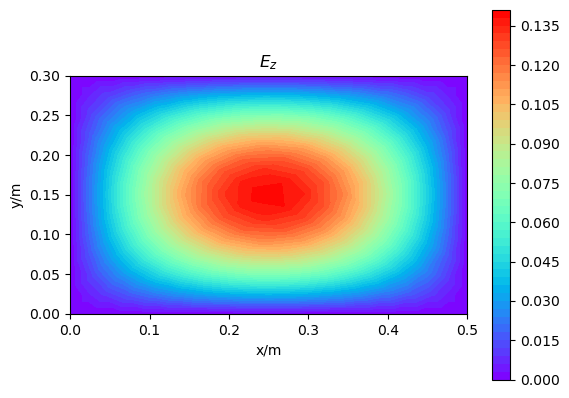

In [108]:
plt.tricontourf(x, y, Ez, levels = 50, cmap = 'rainbow')
# plt.triplot(x, y, 'g-', linewidth=0.1)
plt.colorbar()
plt.axis('image')
plt.title(r'$E_z$')
plt.xlabel('x/m')
plt.ylabel('y/m')
plt.savefig('TM11.png')